In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import scipy

from tqdm import tqdm

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# read in 2D lat lon data, take zonal mean for SST PSL

In [38]:
ds_psl = xr.open_dataset("../CESM_data/CESM1LE_psl_NAtl_19200101_20051201.nc")
ds_moc = xr.open_dataset("../CESM_data/CESM1LE_MOC_NAtl_20N-50N_19200101_20051201.nc")
ds_sst = xr.open_dataset("../CESM_data/CESM1LE_sst_NAtl_19200101_20051201.nc")

In [3]:
psl = ds_psl['psl'][21:54,0:89,:,:].mean(dim=('lon'))

In [4]:
psl_normalized = (psl - psl.mean(dim=('lat','time')))/psl.std(dim=('lat','time'))

In [5]:
sst = ds_sst['sst'][21:54,:,:,:].mean(dim=('lon'))

In [6]:
sst_normalized = (sst - sst.mean(dim=('lat','time')))/sst.std(dim=('lat','time'))

In [7]:
amoc = ds_moc['MOC'].sum(dim='moc_comp').max(dim=('moc_z','lat_aux_grid'))
amoc = amoc - amoc.mean(dim='ensemble')

In [8]:
amoc_normalized = (amoc - amoc.mean(dim='time'))/amoc.std(dim='time') 

In [9]:
sst_flattern = sst_normalized.values.reshape(33,1032*42).astype(np.float32)
psl_flattern = psl_normalized.values.reshape(33,1032*42).astype(np.float32)
amoc_flattern = amoc_normalized.values.reshape(1032*42).astype(np.float32)

In [10]:
data = ( np.array((sst_flattern,psl_flattern)).T.reshape(1032*42,2,33) , amoc_flattern)

In [25]:
percent_train = 0.8

X_train = torch.from_numpy( data[0][0:int(percent_train*1032*42),:,:] )
y_train = torch.from_numpy( data[1][0:int(percent_train*1032*42):] )

X_val = torch.from_numpy( data[0][int(percent_train*1032*42):,:,:] )
y_val = torch.from_numpy( data[1][int(percent_train*1032*42):] )

In [26]:
X_train.shape

torch.Size([34675, 2, 33])

# train 1D CNN ML

In [27]:
model = nn.Sequential(nn.Conv1d(in_channels=2, out_channels=32, kernel_size=5),
          nn.ReLU(),
          nn.MaxPool1d(kernel_size=2),
          nn.Conv1d(in_channels=32,out_channels=64,kernel_size=5),
          nn.ReLU(),
          nn.MaxPool1d(kernel_size=2),
          nn.Flatten(),
          nn.Linear(in_features=5*64,out_features=128),
          nn.ReLU(),
          nn.Dropout(p=0.5),
          nn.Linear(in_features=128,out_features=1))

opt = torch.optim.SGD(model.parameters(), lr = 0.005)
loss_fn = nn.MSELoss()

Test loss before training 1.0127156972885132


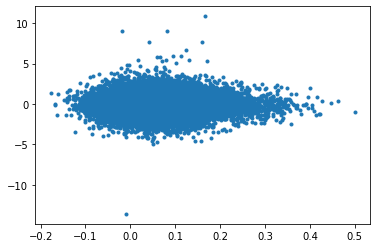

In [28]:
y_pred = model(X_train)
before_train = loss_fn(y_pred.squeeze(), y_train.squeeze())
print('Test loss before training' , before_train.item())
plt.plot(y_pred.detach().numpy(),y_train.numpy(),'.')

In [29]:
epoch = 100

epo_losses = []

model.train()

for i in tqdm(range(epoch)):
    # Forward pass
    y_pred = model(X_train)
    
    # Compute Loss
    loss = loss_fn(y_pred.squeeze(), y_train.squeeze())
    epo_losses.append(loss.item())
    
    # update
    opt.zero_grad()
    loss.backward()
    opt.step()

100%|██████████| 100/100 [01:46<00:00,  1.07s/it]


Text(0, 0.5, 'loss')

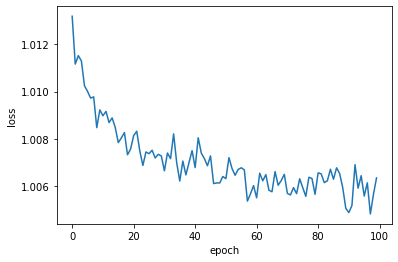

In [30]:
plt.plot(epo_losses)
plt.xlabel('epoch')
plt.ylabel('loss')

In [31]:
model.eval()
y_pred = model(X_train)
after_train = loss_fn(y_pred, y_train) 
print('Test loss after Training' , after_train.item())

/Users/peterw/miniconda3/envs/ml_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([34675])) that is different to the input size (torch.Size([34675, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test loss after Training 0.9144600629806519


Test loss after training 0.9844123721122742


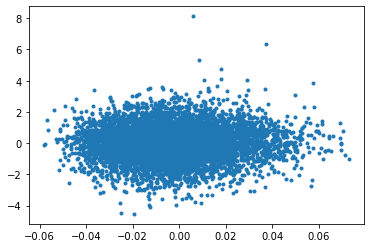

In [33]:
y_pred = model(X_val)
after_train = loss_fn(y_pred.squeeze(), y_val.squeeze())
print('Test loss after training' , after_train.item())
plt.plot(y_pred.detach().numpy(),y_val.numpy(),'.')